In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">MNIST DNN / CNN 이미지 처리</font><b>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋/테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt

In [3]:
# MNIST 데이터 일부(30개)를 출력하기 (plt.imshow)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

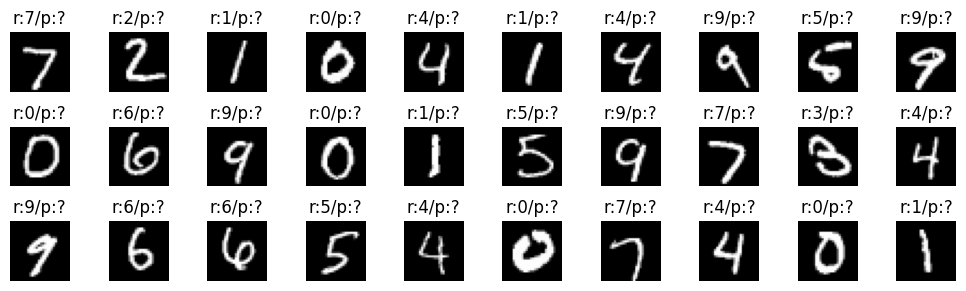

In [12]:
plt_row = 3
plt_col = 10
# plt.figure(figsize=(plt_col, plt_row))
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
# plt.subplots_adjust(hspace=0.4, wspace=0.3)
# axarr[0,0].imshow(X_test[0], cmap='gray')
# axarr[0,0].axis('off')
# axarr[0,0].set_title(f'real:{y_test[0]}')
for i in range(plt_row*plt_col):
    ax = axarr[i//plt_col, i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'r:{y_test[i]}/p:?')
plt.tight_layout()

# 1. DNN

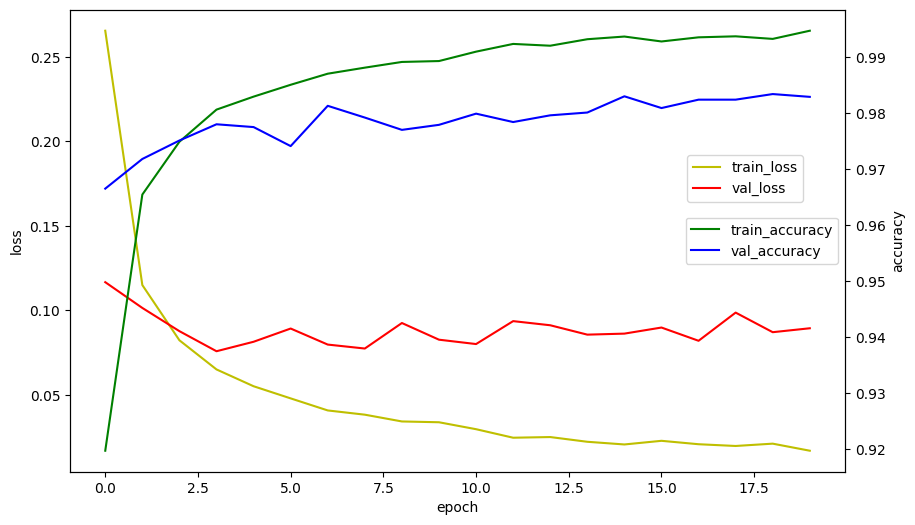

CPU times: total: 6min 38s
Wall time: 1min 15s


In [15]:
%%time
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0

train_Y = to_categorical(y_train, 10)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.2))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

hist = model.fit(train_X, train_Y,
                epochs=20,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0)

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [16]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
acc

0.9836999773979187

In [17]:
len(test_Y) - len(test_Y)*acc

163.000226020813

In [19]:
# 틀린 그림 찾기 - 틀린 이미지만 출력하기 위해, 실제값과 예측값 
# 실제값(들) - 같음
real = test_Y.argmax(axis=1)
real = np.argmax(test_Y, axis=1)
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [20]:
np.all(test_Y.argmax(axis=1) == y_test)

True

In [21]:
#예측값
y_hat = model.predict(test_X, verbose=0).argmax(axis=1)

In [22]:
y_test.shape, y_hat.shape

((10000,), (10000,))

In [23]:
# 성능 평가표 (교차표, 혼동행렬)
pd.crosstab(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,973,1,1,0,0,1,3,1,0,0
1,3,1127,1,2,0,0,0,2,0,0
2,6,0,1012,3,2,0,2,4,3,0
3,0,0,2,999,0,3,0,4,2,0
4,0,0,3,1,963,0,4,1,0,10
5,2,0,0,5,1,878,4,0,1,1
6,3,2,0,1,1,4,946,0,1,0
7,2,1,6,1,1,0,0,1013,2,2
8,5,0,3,10,1,4,1,3,944,3


In [24]:
plt_row = 17
plt_col = 10
i = 0 # y_hat과 y_test를 access할 index : 0~9999
cnt = 0 # image 출력 횟수 : 1~170 (plt_row*plt_col)
while (cnt < plt_row*plt_col) & (i < len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue # !=인 경우 while문 재실행 - 즉, 아래 내용에 else가 필수 아님
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    print(title, end='\t')
    i += 1
    cnt += 1

r:4/p:9	r:9/p:8	r:4/p:2	r:2/p:7	r:5/p:3	r:3/p:7	r:6/p:0	r:3/p:5	r:8/p:2	r:8/p:2	r:7/p:3	r:5/p:8	r:4/p:9	r:8/p:7	r:1/p:3	r:3/p:5	r:8/p:9	r:5/p:4	r:6/p:5	r:7/p:2	r:2/p:3	r:4/p:6	r:7/p:8	r:7/p:2	r:9/p:4	r:4/p:9	r:9/p:3	r:4/p:9	r:8/p:3	r:7/p:9	r:5/p:3	r:2/p:3	r:7/p:9	r:8/p:7	r:4/p:6	r:9/p:3	r:2/p:6	r:3/p:7	r:8/p:0	r:4/p:2	r:7/p:2	r:2/p:8	r:8/p:3	r:9/p:4	r:7/p:8	r:8/p:2	r:6/p:5	r:2/p:0	r:1/p:7	r:8/p:4	r:4/p:9	r:2/p:0	r:3/p:7	r:5/p:9	r:4/p:9	r:6/p:1	r:9/p:1	r:5/p:6	r:8/p:0	r:9/p:6	r:9/p:1	r:8/p:3	r:4/p:9	r:2/p:0	r:2/p:4	r:9/p:7	r:5/p:3	r:7/p:4	r:9/p:0	r:6/p:1	r:8/p:0	r:3/p:2	r:3/p:2	r:9/p:5	r:3/p:5	r:8/p:9	r:1/p:2	r:8/p:3	r:6/p:0	r:9/p:1	r:6/p:4	r:5/p:0	r:8/p:5	r:7/p:1	r:9/p:3	r:8/p:3	r:8/p:0	r:5/p:3	r:4/p:6	r:7/p:0	r:0/p:6	r:6/p:0	r:1/p:3	r:4/p:6	r:9/p:8	r:0/p:2	r:8/p:3	r:9/p:3	r:9/p:7	r:2/p:7	r:1/p:7	r:9/p:7	r:2/p:8	r:9/p:5	r:5/p:6	r:8/p:7	r:9/p:1	r:2/p:7	r:6/p:5	r:4/p:9	r:2/p:4	r:6/p:5	r:8/p:9	r:8/p:3	r:8/p:3	r:9/p:4	r:8/p:6	r:8/p:5	r:8/p:0	r:4/p:3	r:3/p:7	r:7/p:0	r:4/p:9	r:5/p:3	r:3/p:8	

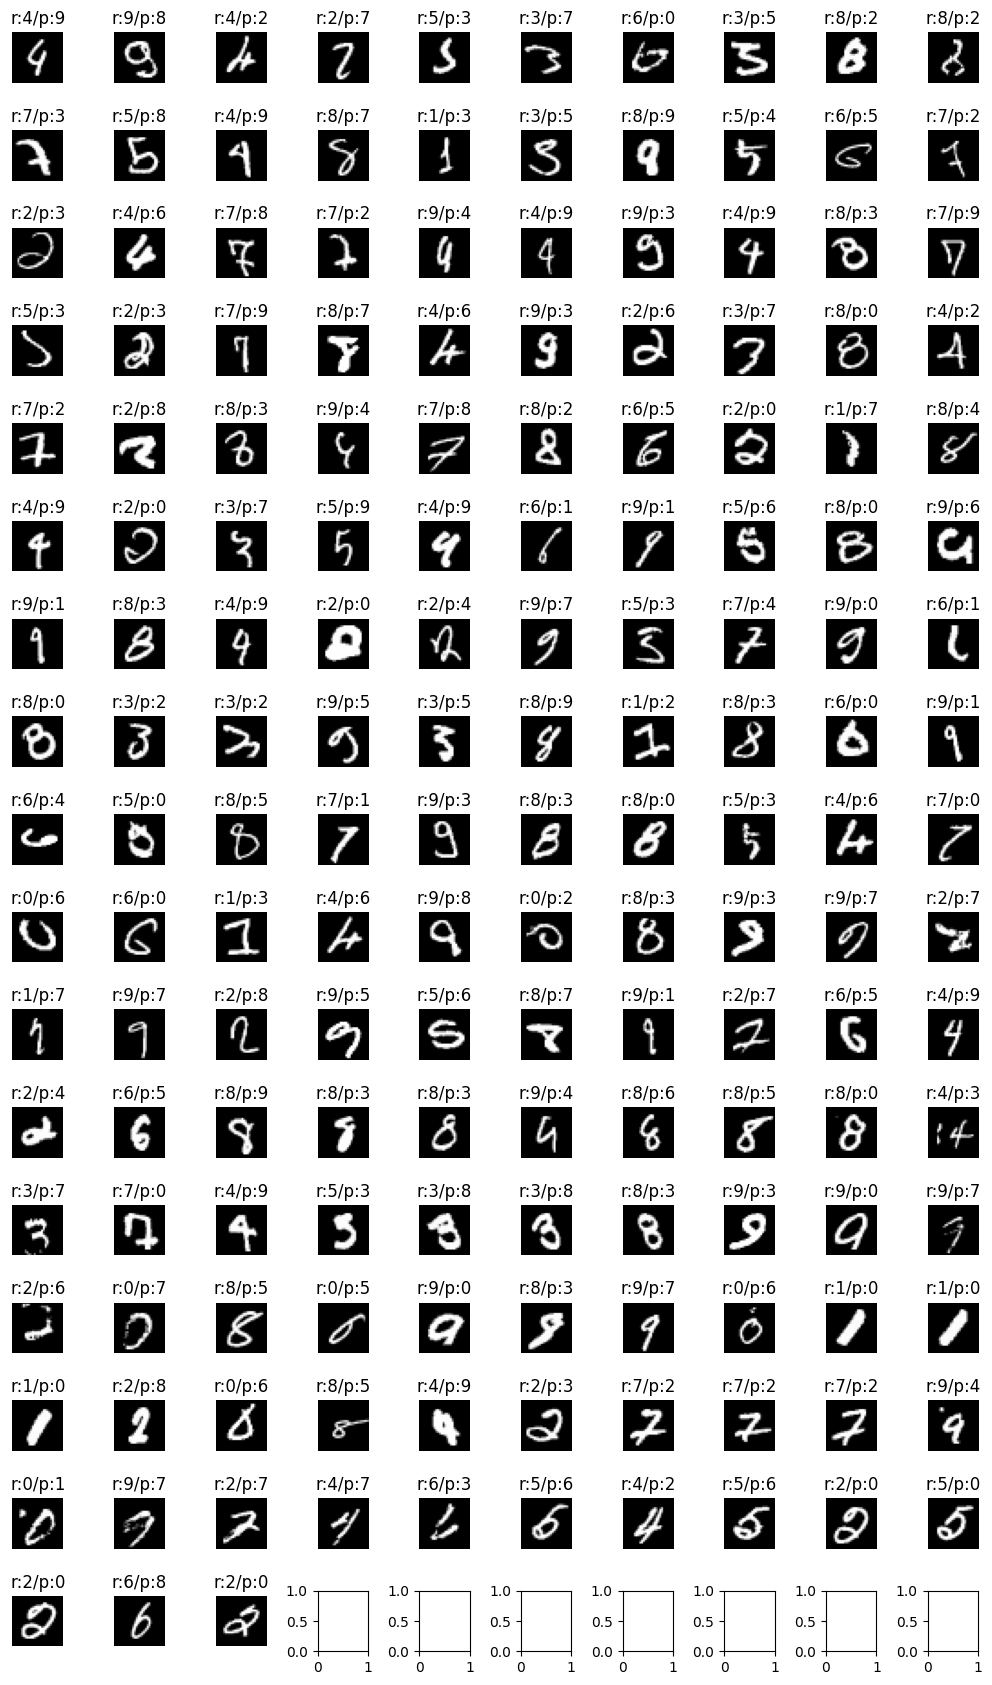

In [26]:
plt_row = 17
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)

i = 0
cnt = 0
while (cnt < plt_row*plt_col) & (i < len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=12)
    i += 1
    cnt += 1
    
plt.tight_layout()

# 2. CNN
- convolution layer → pooling → convolution layer → pooling → flattening(1차원화) → DNN

In [44]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU, Conv2D, MaxPool2D, Flatten #CNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt

In [38]:
width = 28; height = 28
model = Sequential([
    Conv2D(filters = 32, #필터 수
           kernel_size = 3, #필터 사이즈 3x3
           padding='same', # padding='valid' default. / same : input과 같게(zero-padding)
           input_shape = (width, height, 1), # 채널 수 - 1: grayscale, 3: rgb, 4: rgb+transparency
           activation='relu'
          ), #28x28 1채널 이미지를 32개 필터로 특성맵 추출 28*28*32개 특성맵
    MaxPool2D(pool_size=(2,2)), # 가로 2배, 세로 2배 - 전체 4배 줄어듦 (pool_size=(2,2) default)
    Dropout(0.1),
    Conv2D(64, (3,3), activation='relu'), 
    MaxPool2D(),
    Dropout(0.25),
    Flatten(), # (6,6,24) → 2304
    Dense(units=128, activation='relu'),
    Dropout(0.4),
    Dense(10, 'softmax')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 6, 6, 64)         

In [41]:
# 1. 데이터 생성 및 전처리
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X 2차원 그대로 넣어야 해.
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
# Scale 조정
train_X = X_train.astype('float32')/255.0
val_X = X_val.astype('float32')/255.0
test_X = X_test.astype('float32')/255.0

train_Y = to_categorical(y_train)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

train_X.shape, val_X.shape, test_X.shape, train_Y.shape, val_Y.shape, test_Y.shape

((50000, 28, 28),
 (10000, 28, 28),
 (10000, 28, 28),
 (50000, 10),
 (10000, 10),
 (10000, 10))

In [45]:
%%time

# 2. 모델 생성
width = 28; height = 28

model = Sequential()
model.add(Conv2D(32, 3, padding='same', input_shape=(width, height, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# 3. 학습 과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 학습하기
early_stopping = EarlyStopping(patience=10)

model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
file = model_save_folder + 'mnist-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(
                filepath = file,
                monitor='val_accuracy',
                save_best_only=True,
                mode = 'max',
                verbose=1
)
hist = model.fit(train_X, train_Y, epochs=50, batch_size=32, validation_data=(val_X, val_Y), verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/50
1559/1563 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9310
Epoch 1: val_accuracy improved from -inf to 0.98360, saving model to ./model\mnist-001-val0.9836.h5
1563/1563 [==============================] - 21s 14ms/step - loss: 0.2206 - accuracy: 0.9310 - val_loss: 0.0539 - val_accuracy: 0.9836
Epoch 2/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9746
Epoch 2: val_accuracy improved from 0.98360 to 0.98620, saving model to ./model\mnist-002-val0.9862.h5
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0841 - accuracy: 0.9746 - val_loss: 0.0452 - val_accuracy: 0.9862
Epoch 3/50
1560/1563 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9808
Epoch 3: val_accuracy improved from 0.98620 to 0.99040, saving model to ./model\mnist-003-val0.9904.h5
1563/1563 [==============================] - 21s 14ms/step - loss: 0.0620 - accuracy: 0.9809 - val_loss: 0.0375 - val_accuracy: 0.

vggnet, rcnn 추가로 참고

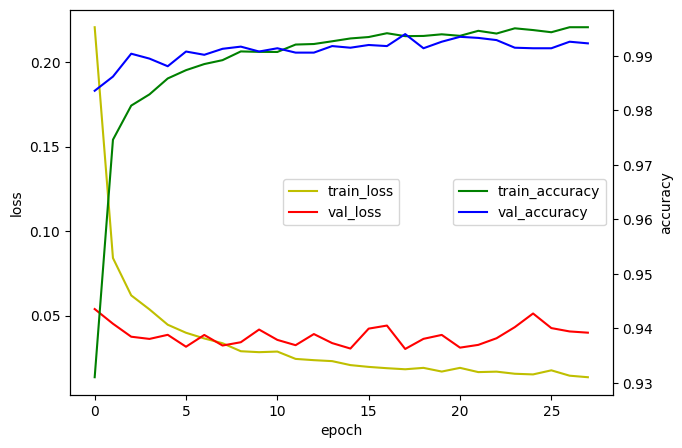

In [46]:
# 학습 과정 시각화

fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [47]:
# 모델 평가 - 최종모델
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
print('최종 모델: ', acc, loss)

최종 모델:  0.9929999709129333 0.027487292885780334


In [48]:
# 모델 평가 - 저장모델 epoch18
model1 = load_model('./model/mnist-018-val0.9940.h5')
loss1, acc1 = model1.evaluate(test_X, test_Y, verbose=0)
print('최종 모델: ', acc1, loss1)
# 최종 모델보다 저장 모델이 더 낫네!

최종 모델:  0.9937000274658203 0.022240398451685905


In [49]:
# 모델 평가 - 저장모델 epoch16 ✨ model2 이걸로 채택!
model2 = load_model('./model/mnist-016-val0.9920.h5')
loss2, acc2 = model2.evaluate(test_X, test_Y, verbose=0)
print('최종 모델: ', acc2, loss2)
# val_acc 낮았는데, 이게 더 높아?

최종 모델:  0.9939000010490417 0.02339673601090908


In [50]:
# 모델 평가 - 저장모델 epoch14
model3 = load_model('./model/mnist-014-val0.9918.h5')
loss3, acc3 = model3.evaluate(test_X, test_Y, verbose=0)
print('최종 모델: ', acc3, loss3)
# 얘는 아니네.

최종 모델:  0.9927999973297119 0.023046167567372322


In [51]:
# 성능평가(성능평가지표 - 교차표, 혼동행렬, acc, recall, precision, f1)를 위해 실제값 / 예측값 확인
# 실제값: y_test
# 예측값
y_hat = model2.predict(test_X, verbose=0).argmax(axis=1)

In [52]:
# 성능 평가표 (교차표, 혼동행렬)
pd.crosstab(y_test, y_hat)
# confusion_matrix(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,978,0,0,0,0,0,2,0,0,0
1,0,1135,0,0,0,0,0,0,0,0
2,2,1,1024,0,1,0,0,4,0,0
3,0,0,0,1006,0,2,0,0,1,1
4,0,1,0,0,977,0,1,0,0,3
5,2,0,0,1,0,886,2,1,0,0
6,4,1,0,0,2,1,950,0,0,0
7,0,1,2,1,0,0,0,1022,1,1
8,2,1,2,1,0,1,0,0,965,2


In [57]:
print('accuracy: ', accuracy_score(y_test, y_hat))
# 다중분류의 타깃변수 균형이 비슷하면 'macro' / 균형이 안 잡힌 데이터면 'weighted'
print('recall: ', recall_score(y_test, y_hat, average='weighted'))
print('precision: ', precision_score(y_test, y_hat, average='weighted'))
print('f1_score: ', f1_score(y_test, y_hat, average='weighted'))

accuracy:  0.9939
recall:  0.9939
precision:  0.9939085356810577
f1_score:  0.9938983962126973


In [58]:
len(y_test) - len(y_test)*acc2

60.99998950958252

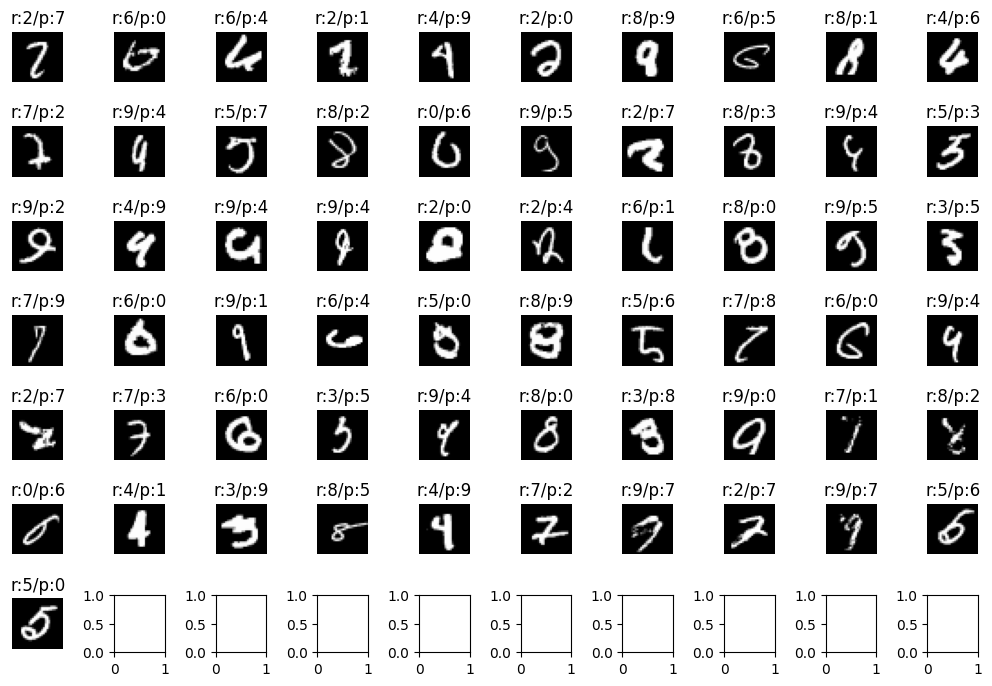

In [59]:
plt_row = 7
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)

i = 0
cnt = 0
while (cnt < plt_row*plt_col) & (i < len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=12)
    i += 1
    cnt += 1
    
plt.tight_layout()